# Embedding Geometry Experiment

This notebook tests whether embedding geometry causally determines reasoning style in LLM categorization.

**Hypothesis**: Tight exemplar clusters → rigid reasoning; Loose clusters → flexible reasoning

**Method**: Manipulate dog/cat/hamster embeddings, test on edge cases (monkey, snake, fish, spider)

## Setup

In [1]:
from embedding_utils import get_token_ids, compute_centroid, modify_embeddings, print_modification_stats

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull

In [3]:
MODEL_NAME = "openai/gpt-oss-20b"
EDGE_CASES = ["monkey", "snake", "fish", "spider"]
CONDITIONS = {
    "baseline": None,  # No modification
    "tight": 0.5,      # Move 50% closer to centroid
    "loose": 2.0,      # Move 100% farther (2x distance from centroid)
}
PROMPT_TEMPLATE = "Is a {item} a pet? Answer yes or no, then explain your reasoning."
RESULTS_DIR = "results"

## Load Model

In [ ]:
print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
print("✓ Model loaded")

## Check Token IDs for Candidate Exemplars

First, let's verify which pet words tokenize to single tokens (we need single-token words for clean embedding manipulation):

In [5]:
# Check tokenization of candidate exemplar words
candidates = [
    "dog", "cat", "hamster", "bird", "fish", "rat", "pig",
    "rabbit", "mouse", "horse", "cow", "sheep", "goat"
]

print("Checking which words tokenize to single tokens:\\n")
single_token = []
multi_token = []

for word in candidates:
    tokens = tokenizer.encode(word, add_special_tokens=False)
    if len(tokens) == 1:
        print(f"  ✓ {word:10} -> token {tokens[0]}")
        single_token.append(word)
    else:
        print(f"  ✗ {word:10} -> {tokens} ({len(tokens)} tokens)")
        multi_token.append(word)

print(f"Single-token words: {single_token}")
print(f"Multi-token words: {multi_token}")
print(f"\nWe use {single_token[:3]} as EXEMPLARS")
EXEMPLARS = single_token[:3]

Checking which words tokenize to single tokens:\n
  ✓ dog        -> token 30146
  ✓ cat        -> token 8837
  ✗ hamster    -> [6595, 3968] (2 tokens)
  ✓ bird       -> token 32981
  ✓ fish       -> token 29277
  ✓ rat        -> token 11990
  ✓ pig        -> token 131332
  ✓ rabbit     -> token 180596
  ✓ mouse      -> token 25673
  ✓ horse      -> token 105889
  ✓ cow        -> token 175080
  ✗ sheep      -> [45842, 1027] (2 tokens)
  ✗ goat       -> [2319, 266] (2 tokens)
Single-token words: ['dog', 'cat', 'bird', 'fish', 'rat', 'pig', 'rabbit', 'mouse', 'horse', 'cow']
Multi-token words: ['hamster', 'sheep', 'goat']

We use ['dog', 'cat', 'bird'] as EXEMPLARS


## Inspect Original Embedding Geometry

In [6]:
embeddings = model.get_input_embeddings()
token_ids = get_token_ids(tokenizer, EXEMPLARS)
centroid = compute_centroid(embeddings, token_ids)

print("Original distances to centroid:")
for word, tid in zip(EXEMPLARS, token_ids):
    vec = embeddings.weight[tid]
    dist = (vec - centroid).norm().item()
    print(f"  {word:10}: {dist:.4f}")

print(f"\nEmbedding shape: {embeddings.weight[token_ids[0]].shape}")
print(f"Embedding dtype: {embeddings.weight[token_ids[0]].dtype}")

Original distances to centroid:
  dog       : 65.8125
  cat       : 76.6250
  bird      : 74.5000

Embedding shape: torch.Size([2880])
Embedding dtype: torch.float16


Using context words: ['snake', 'fish', 'car', 'table', 'book', 'tree']



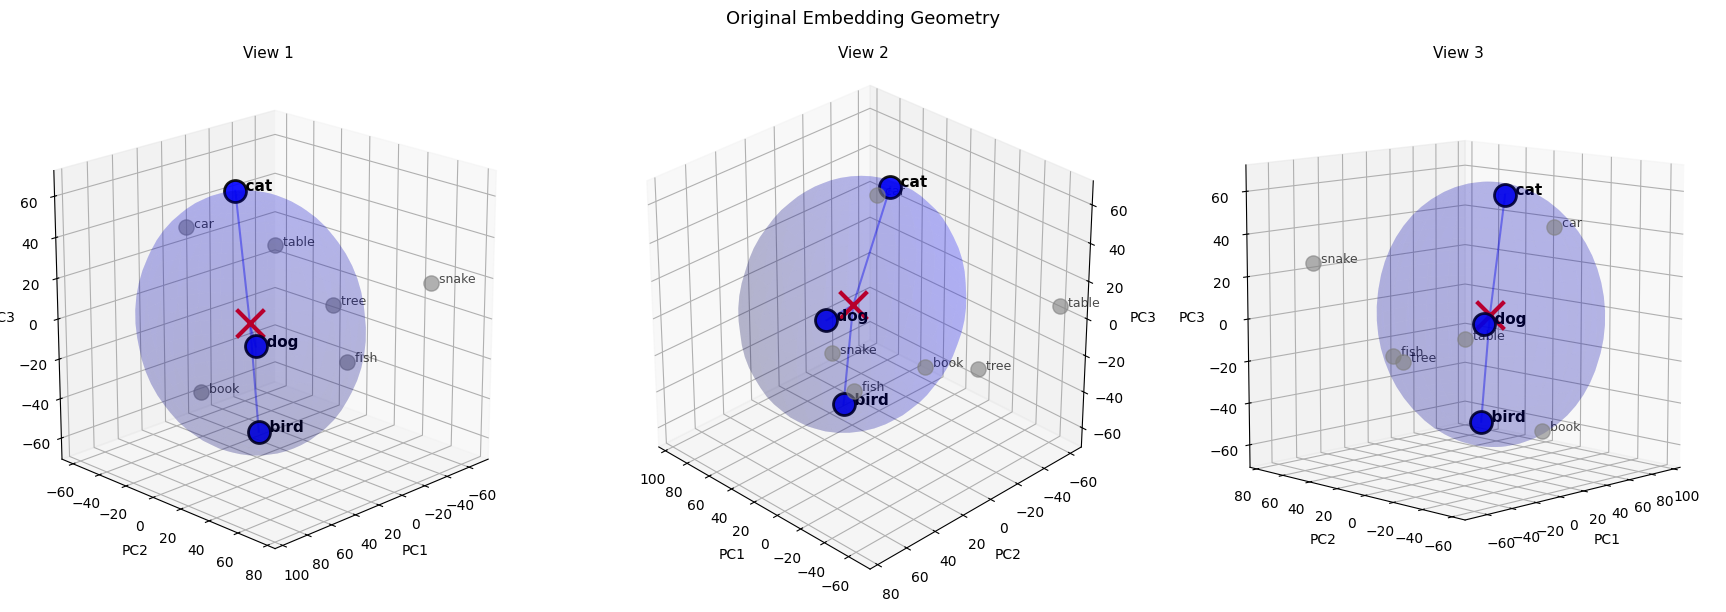

: 

In [ ]:
# Add context words to visualize
context_candidates = ["snake", "fish", "car", "table", "book", "tree", 
                      "horse", "cow", "pig", "lion", "bear", "wolf", "fox"]

# Filter to single-token words only
context_words = []
for word in context_candidates:
    tokens = tokenizer.encode(word, add_special_tokens=False)
    if len(tokens) == 1:
        context_words.append(word)
    if len(context_words) >= 6:
        break

print(f"Using context words: {context_words}\n")

all_words = EXEMPLARS + context_words

# Get embeddings for all words
all_token_ids = get_token_ids(tokenizer, all_words)
all_vecs = [embeddings.weight[tid].detach().cpu().numpy() for tid in all_token_ids]

# Project to 3D using PCA
pca = PCA(n_components=3)
vecs_3d = pca.fit_transform(all_vecs)

# Separate exemplars from context
exemplar_vecs = vecs_3d[:len(EXEMPLARS)]
context_vecs = vecs_3d[len(EXEMPLARS):]
centroid_3d = exemplar_vecs.mean(axis=0)

# Calculate distances
distances = [np.linalg.norm(v - centroid_3d) for v in exemplar_vecs]
max_dist = max(distances)

# Create sphere
def make_sphere(center, radius, resolution=30):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    return x, y, z

# Function to plot from one angle
def plot_view(ax, elev, azim, title):
    # Draw sphere
    x_sphere, y_sphere, z_sphere = make_sphere(centroid_3d, max_dist)
    ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.15, color='blue', edgecolor='none')
    
    # Draw lines from centroid to exemplars
    for vec in exemplar_vecs:
        ax.plot([centroid_3d[0], vec[0]], 
                [centroid_3d[1], vec[1]], 
                [centroid_3d[2], vec[2]], 
                'b-', alpha=0.4, linewidth=1.5)
    
    # Plot exemplars (blue)
    ax.scatter(exemplar_vecs[:, 0], exemplar_vecs[:, 1], exemplar_vecs[:, 2], 
               s=250, c='blue', alpha=0.9, edgecolors='black', linewidth=2, depthshade=False)
    
    # Plot context words (gray)
    ax.scatter(context_vecs[:, 0], context_vecs[:, 1], context_vecs[:, 2], 
               s=120, c='gray', alpha=0.6, depthshade=False)
    
    # Plot centroid (red X)
    ax.scatter(centroid_3d[0], centroid_3d[1], centroid_3d[2], 
               s=400, c='red', marker='x', linewidths=3, depthshade=False)
    
    # Labels for exemplars
    for i, word in enumerate(EXEMPLARS):
        ax.text(exemplar_vecs[i, 0], exemplar_vecs[i, 1], exemplar_vecs[i, 2], 
                f'  {word}', fontsize=11, fontweight='bold', ha='left')
    
    # Labels for ALL context words
    for i, word in enumerate(context_words):
        ax.text(context_vecs[i, 0], context_vecs[i, 1], context_vecs[i, 2], 
                f'  {word}', fontsize=9, alpha=0.7, ha='left')
    
    ax.set_xlabel(f"PC1", fontsize=10)
    ax.set_ylabel(f"PC2", fontsize=10)
    ax.set_zlabel(f"PC3", fontsize=10)
    ax.set_title(title, fontsize=11)
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1,1,1])

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
plot_view(ax1, elev=20, azim=45, title="View 1")

ax2 = fig.add_subplot(132, projection='3d')
plot_view(ax2, elev=30, azim=135, title="View 2")

ax3 = fig.add_subplot(133, projection='3d')
plot_view(ax3, elev=10, azim=225, title="View 3")

plt.suptitle(f"Original Embedding Geometry\n", 
             fontsize=13, y=0.98)
plt.tight_layout()
plt.show()

## Experiment on Distances

In [ ]:
from IPython.display import display, clear_output
import sys

def generate_response(model, tokenizer, prompt, max_new_tokens=150, stream=True):
    """Generate model response with optional streaming."""
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    if stream:
        # Streaming generation
        generated_text = ""
        with torch.no_grad():
            for _ in range(max_new_tokens):
                outputs = model(**inputs)
                next_token_logits = outputs.logits[:, -1, :]
                next_token_id = torch.argmax(next_token_logits, dim=-1)
                
                # Check for EOS
                if next_token_id.item() == tokenizer.eos_token_id:
                    break
                
                # Decode and print token
                token_text = tokenizer.decode(next_token_id, skip_special_tokens=True)
                generated_text += token_text
                print(token_text, end='', flush=True)
                
                # Update inputs for next iteration
                inputs['input_ids'] = torch.cat([inputs['input_ids'], next_token_id.unsqueeze(0)], dim=1)
                if 'attention_mask' in inputs:
                    inputs['attention_mask'] = torch.cat([
                        inputs['attention_mask'], 
                        torch.ones((1, 1), device=inputs['attention_mask'].device)
                    ], dim=1)
        
        print()  # New line after streaming
        return generated_text
    else:
        # Non-streaming (original behavior)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )
        
        generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
        response = tokenizer.decode(generated_ids, skip_special_tokens=True)
        return response

# Test it
test_prompt = "Is a dog a pet? Answer yes or no, then explain."
print(f"Test prompt: {test_prompt}\nResponse: ", end='')
test_response = generate_response(model, tokenizer, test_prompt, stream=True)

In [ ]:
def run_condition(condition_name, scale_factor, model, tokenizer):
    """Run experiment for one condition."""
    print(f"\n{'#'*60}")
    print(f"# Condition: {condition_name}")
    print(f"{'#'*60}")
    
    # Modify embeddings (if not baseline)
    if scale_factor is not None:
        stats = modify_embeddings(model, tokenizer, EXEMPLARS, scale_factor)
        print_modification_stats(stats, condition_name)
    else:
        print("\nBaseline - no modification")
    
    # Create results directory
    condition_dir = Path(RESULTS_DIR) / condition_name
    condition_dir.mkdir(parents=True, exist_ok=True)
    
    # Test each edge case
    results = {}
    for edge_case in EDGE_CASES:
        print(f"\nTesting: {edge_case}...")
        prompt = PROMPT_TEMPLATE.format(item=edge_case)
        response = generate_response(model, tokenizer, prompt)
        
        # Save
        output_file = condition_dir / f"{edge_case}.txt"
        with open(output_file, "w") as f:
            f.write(f"Prompt: {prompt}\n\n")
            f.write(f"Response: {response}\n")
        
        results[edge_case] = response
        print(f"  Response: {response[:100]}...")
    
    # Save summary
    summary = {
        "condition": condition_name,
        "scale_factor": scale_factor,
        "exemplars": EXEMPLARS,
        "results": results,
    }
    with open(condition_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n✓ Condition '{condition_name}' complete")
    return results

### Baseline:

In [ ]:
baseline_results = run_condition("baseline", None, model, tokenizer)


############################################################
# Condition: baseline
############################################################

Baseline - no modification

Testing: monkey...


NameError: name 'generate_response' is not defined